# Predição do alfabeto de sinais

## Libs utilizadas no desenvolvimento

In [29]:
import csv
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

## Leitura e Modelagem dos Dados

In [2]:
def get_data(filename):
    with open(filename) as training_file:
        training_reader = csv.reader(training_file, delimiter=',')
        image = []
        labels = []
        line_count = 0
        for row in training_reader:
            if line_count == 0:
                line_count +=1
            else:
                labels.append(row[0])
                temp_image = row[1:785]
                image_data_as_array = np.array_split(temp_image, 28)
                image.append(image_data_as_array)
                line_count += 1
        images = np.array(image).astype('float32')
        labels = np.array(labels).astype('float32')
        print(f'Processed {line_count} lines.')

    return images, labels

In [3]:
train_imgs, train_labels = get_data("../datasets/sign_mnist_train.csv")
test_imgs, test_labels = get_data("../datasets/sign_mnist_test.csv")

print("Total Training images", train_imgs.shape)
print("Total Training labels",train_labels.shape)
print("Total Testing images",test_imgs.shape)
print("Total Testing labels",test_labels.shape)

Processed 27456 lines.
Processed 7173 lines.
Total Training images (27455, 28, 28)
Total Training labels (27455,)
Total Testing images (7172, 28, 28)
Total Testing labels (7172,)


In [4]:
# Mapeamento das letras do alfabeto de acordo com a posição dela
alphabets = string.ascii_lowercase
map_letter =  {}

for i, letter in enumerate(alphabets):
    map_letter[letter] = i
map_letter = {v:k for k, v in map_letter.items()}

train_labels_s = pd.Series(train_labels).map(map_letter)
test_labels_s = pd.Series(test_labels).map(map_letter)

## Vizualização Geral dos Dados

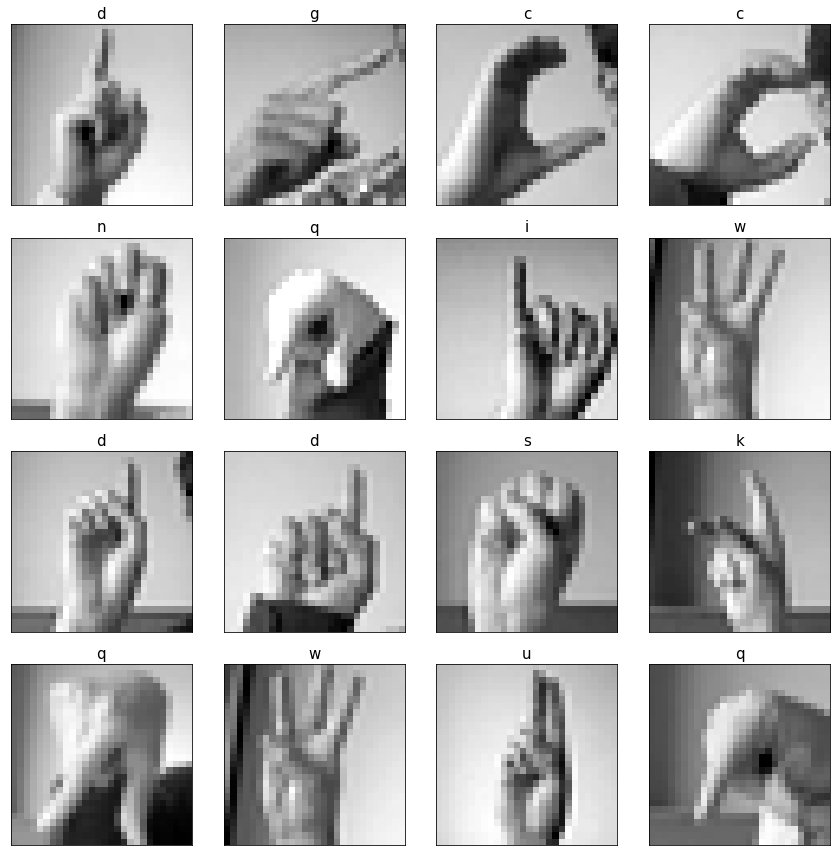

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = train_imgs[i].reshape(28,28)
    ax.imshow(img, cmap='gray')
    title = train_labels_s[i]
    ax.set_title(title, fontsize=15)
plt.tight_layout()
plt.show()

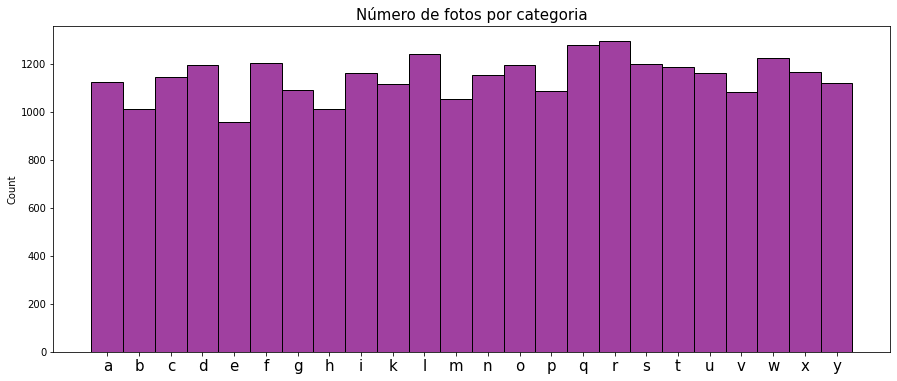

In [19]:
plt.figure(figsize=(15,6))
sns.histplot(sorted(train_labels_s), color='purple')
plt.title("Número de fotos por categoria", fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Data Augmentation

In [7]:
train_imgs_s = np.expand_dims(train_imgs, axis=3)
test_imgs_s = np.expand_dims(test_imgs, axis=3)

print(train_imgs_s.shape)
print(test_imgs_s.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   rotation_range=10,
                                   fill_mode='nearest',
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_datagenerator = train_datagen.flow(train_imgs_s, train_labels, batch_size=32)

validation_datagenerator = validation_datagen.flow(test_imgs_s, test_labels, batch_size=32)

## Definição de um Callback personalizado

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.99):
            print("\nCancelando treinamento devido a acurácia de 99%!")
            self.model.stop_training = True

## Construção do Modelo

### Arquitetura do Modelo

In [10]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(25, activation='softmax'))

### Sumário do Modelo

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 512)         590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

### Treinamento e Parâmetros do Modelo

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                            patience = 2, 
                                                            verbose=1,factor=0.25, 
                                                            min_lr=0.0001)

callbacks = myCallback()

history = model.fit(train_datagenerator,
                    validation_data = validation_datagenerator,
                    steps_per_epoch = len(train_labels)//32,
                    epochs = 100,
                    validation_steps = len(test_labels)//32,
                    callbacks = [callbacks, learning_rate_reduction])

model.save('../models/model.h5')

Epoch 1/100
857/857 [==============================] - 53s 61ms/step - loss: 1.9963 - accuracy: 0.3404 - val_loss: 0.8024 - val_accuracy: 0.7200
Epoch 2/100
857/857 [==============================] - 51s 59ms/step - loss: 0.6382 - accuracy: 0.7752 - val_loss: 0.3345 - val_accuracy: 0.8792
Epoch 3/100
857/857 [==============================] - 50s 58ms/step - loss: 0.3262 - accuracy: 0.8877 - val_loss: 0.1564 - val_accuracy: 0.9385
Epoch 4/100
857/857 [==============================] - 50s 59ms/step - loss: 0.2144 - accuracy: 0.9260 - val_loss: 0.0994 - val_accuracy: 0.9647
Epoch 5/100
857/857 [==============================] - 51s 59ms/step - loss: 0.1509 - accuracy: 0.9496 - val_loss: 0.0928 - val_accuracy: 0.9661
Epoch 6/100
857/857 [==============================] - 51s 59ms/step - loss: 0.1319 - accuracy: 0.9562 - val_loss: 0.1234 - val_accuracy: 0.9685
Epoch 7/100
857/857 [==============================] - 50s 58ms/step - loss: 0.1107 - accuracy: 0.9648 - val_loss: 0.1635 - val_ac

### Gráficos do Treinamento

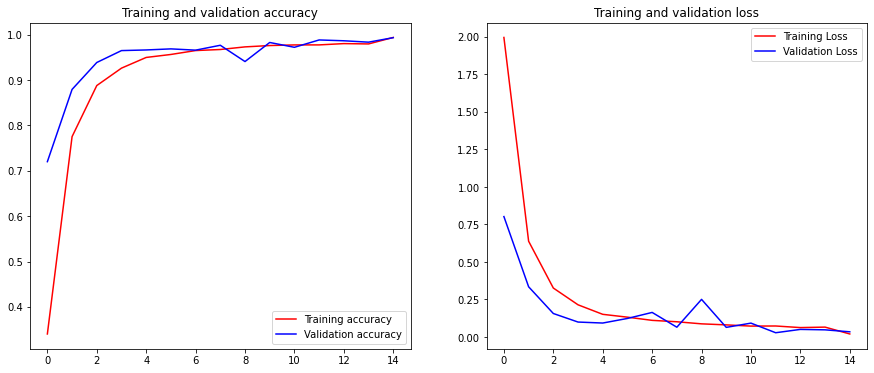

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

axes[0].plot(epochs, acc, 'r', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Training Loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation Loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()

plt.show()

### Carregando o Modelo

In [23]:
model_load = keras.models.load_model('../models/model.h5')

In [28]:
model_load.evaluate(test_imgs_s, test_labels, return_dict=True)

225/225 [==============================] - 2s 8ms/step - loss: 37.1623 - accuracy: 0.9182


{'loss': 37.16225051879883, 'accuracy': 0.9181539416313171}

## Avaliando as Métricas do Modelo

### Acurácia Geral

In [30]:
pred = model.predict(test_imgs_s)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(test_labels,pred)

# Display the results
print(f'## {acc*100:.2f}% accuracy on the test set')

## 91.82% accuracy on the test set


### Classification Report

In [31]:
y_test_letters = [map_letter[x] for x in test_labels]
pred_letters = [map_letter[x] for x in pred]

print(classification_report(y_test_letters, pred_letters))

              precision    recall  f1-score   support

           a       1.00      0.87      0.93       331
           b       1.00      0.87      0.93       432
           c       1.00      0.87      0.93       310
           d       0.93      0.90      0.91       245
           e       0.93      0.92      0.92       498
           f       0.84      1.00      0.91       247
           g       0.88      0.91      0.89       348
           h       1.00      0.75      0.86       436
           i       1.00      1.00      1.00       288
           k       0.98      0.90      0.94       331
           l       1.00      1.00      1.00       209
           m       1.00      0.91      0.95       394
           n       0.80      1.00      0.89       291
           o       0.86      1.00      0.92       246
           p       0.98      0.87      0.92       347
           q       0.58      1.00      0.74       164
           r       0.70      0.85      0.77       144
           s       0.69    

### Matrix de Confusão

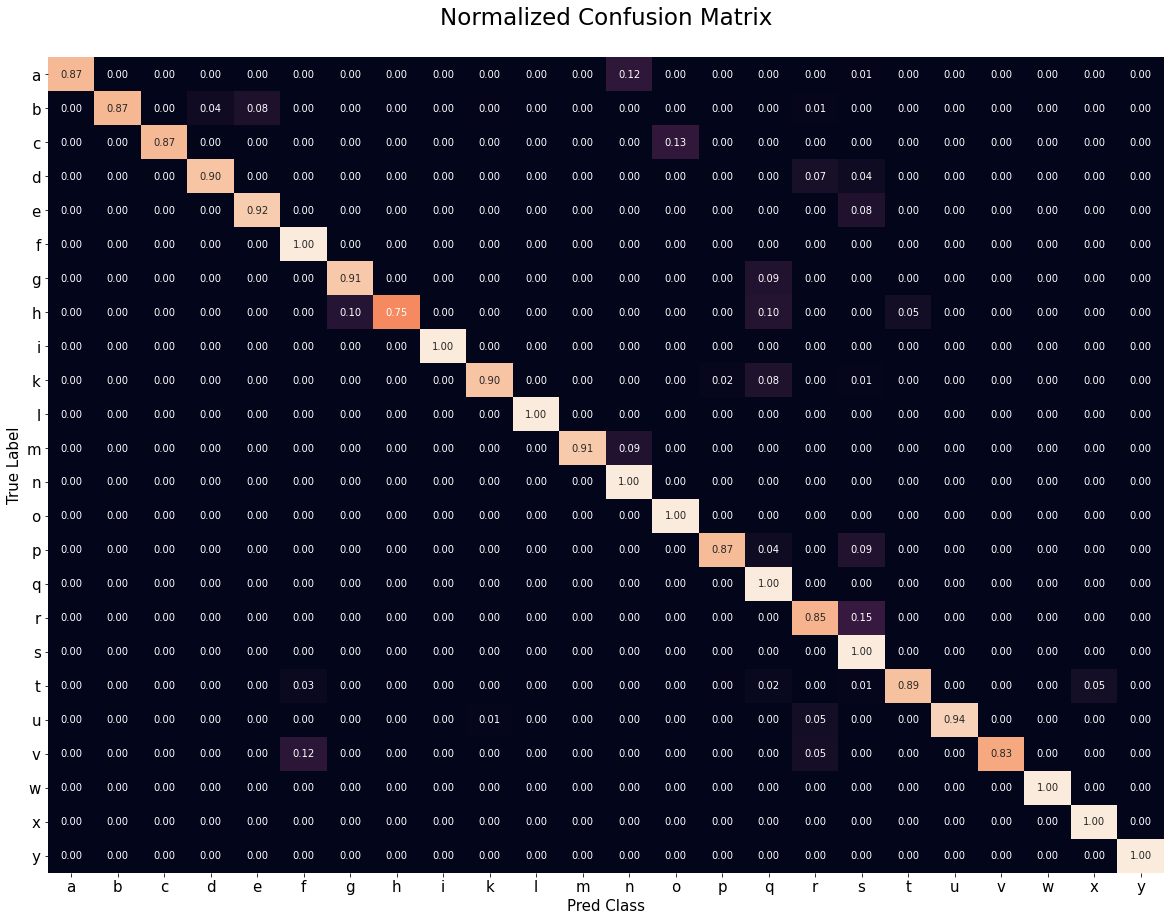

In [34]:
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, fmt='.2f', xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Pred Class",fontsize=15)
plt.ylabel("True Label",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

### Casos de Acerto

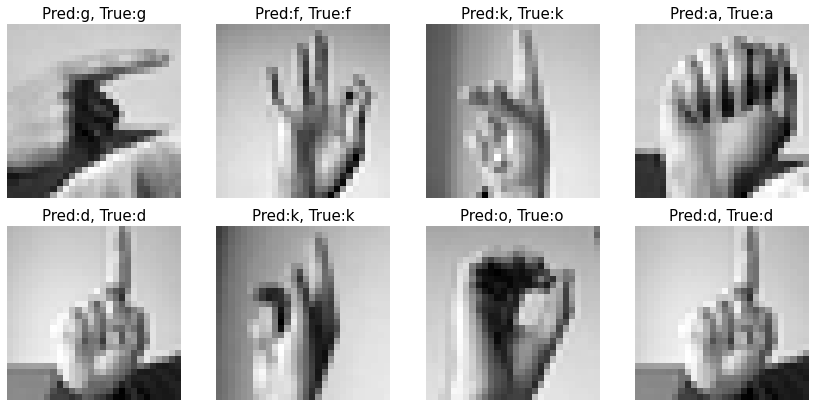

In [43]:
correct = np.nonzero(pred == test_labels)[0]
plt.figure(figsize=(12, 6))
i = 0
for c in correct[:8]:
    plt.subplot(2,4,i+1)
    plt.imshow(test_imgs[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Pred:{}, True:{}".format(pred_letters[c], y_test_letters[c]), size=15)
    plt.tight_layout()
    plt.axis('off')
    i += 1

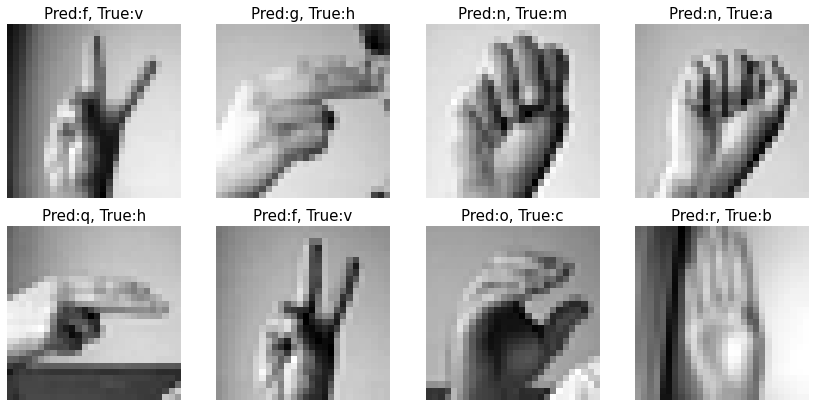

In [45]:
wrong = np.nonzero(pred != test_labels)[0]
plt.figure(figsize=(12, 6))
i = 0
for c in wrong[:8]:
    plt.subplot(2,4,i+1)
    plt.imshow(test_imgs[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Pred:{}, True:{}".format(pred_letters[c], y_test_letters[c]), size=15)
    plt.tight_layout()
    plt.axis('off')
    i += 1